<a href="https://colab.research.google.com/github/sudiraO21/Inverse_Problem/blob/main/Mini_Project_Direct_Inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# # Pre-Midterm Mini-Project: Direct Inversion - A Simple Seismic Tomography

**Objectives:**
1. Perform direct inversion using noiseless data.
2. Analyze the effect of adding noise to the data on the inversion result.
3. Analyze the effect of adding errors to the kernel matrix (G) on the inversion result.
4. Answer analysis questions regarding the quality of the inverted model.

## 1. Initialization and Student Data Input

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# The last three digits Student ID number (NIU) will be used to generate a unique slowness model (`m_true`).
STUDENT_ID = '281'

# Set a more appealing plot style
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Model Setup and Geometry

### Unique Model Based on Student ID
The model consists of 9 blocks (3x3). The true slowness (`m_true`) will be made unique by adding a small variation based on the last 3 digits of NIU to a base model.

### Source-Receiver Geometry
All coordinates are on the edges of the model (0 to 3 km) with a 0.5 km increment. The layout remains asymmetrical to ensure unique raypaths and a stable G matrix.

In [4]:
# --- Grid Parameters ---
NX = 3  # Number of horizontal blocks
NY = 3  # Number of vertical blocks
M = NX * NY  # Total number of model parameters
GRID_SIZE = 1.0  # Size of each block (km)

# --- Create a Unique Slowness Model (m_true) from Student ID ---
try:
    # Take the last 3 digits of the NIM
    nim_digits = [int(d) for d in STUDENT_ID[-3:]]

    # Base model (s/km)
    m_base_row1 = 0.5
    m_base_row2 = 0.4
    m_base_row3 = 0.3

    # Add variation based on NIM
    m_true = np.array([
        m_base_row1 + (nim_digits[0] * 0.005), m_base_row1 + (nim_digits[0] * 0.005), m_base_row1 + (nim_digits[0] * 0.005),
        m_base_row2 + (nim_digits[1] * 0.005), m_base_row2 + (nim_digits[1] * 0.005), m_base_row2 + (nim_digits[1] * 0.005),
        m_base_row3 + (nim_digits[2] * 0.005), m_base_row3 + (nim_digits[2] * 0.005), m_base_row3 + (nim_digits[2] * 0.005)
    ])
    print(f"The unique m_true model (based on NIM ...{STUDENT_ID[-3:]}):\n", np.round(m_true, 4))
except (ValueError, IndexError):
    print("Invalid Student ID. Using default model. Please replace the STUDENT_ID variable.")
    m_true = np.array([0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3])


# --- Source (S) and Receiver (R) Coordinates ---
# Asymmetrical configuration with a 0.5 km scale on the edges.
sources = [
    [0.0, 0.5],  # Left-Top
    [2.5, 0.0],  # Top-Right
    [2.0, 0.0],  # Top-Center
    [3.0, 0.5],  # Right-Top
    [0.0, 1.5],  # Left-Center
    [3.0, 2.5],  # Right-Bottom
    [0.5, 3.0],  # Bottom-Left
    [0.0, 2.5],  # Left-Bottom
    [0.0, 3.0]   # Left-Bottom corner
]

receivers = [
    [3.0, 2.0],  # Right-Center
    [2.5, 3.0],  # Bottom-Right
    [0.0, 2.0],  # Left-Center
    [1.0, 3.0],  # Bottom-Center
    [3.0, 1.0],  # Right-Center
    [0.0, 1.0],  # Left-Center
    [1.5, 0.0],  # Top-Center
    [1.5, 3.0],  # Bottom-Center
    [3.0, 0.0]   # Right-Top corner
]

N = len(sources) # Number of data points

The unique m_true model (based on NIM ...281):
 [0.51  0.51  0.51  0.44  0.44  0.44  0.305 0.305 0.305]


In [5]:
# --- Visualization Helper Functions ---
def plot_base_model_with_labels(ax, m, title):
    """(NEW) Plots the slowness model with m1, m2, etc. labels and values."""
    m_reshaped = m.reshape((NY, NX))
    vmin, vmax = m_true.min() - 0.05, m_true.max() + 0.05
    im = ax.imshow(m_reshaped, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax,
                   extent=[0, NX*GRID_SIZE, NY*GRID_SIZE, 0])

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Slowness (s/km)', rotation=270, labelpad=15)

    ax.set_xticks(np.arange(0, NX*GRID_SIZE + 1, GRID_SIZE))
    ax.set_yticks(np.arange(0, NY*GRID_SIZE + 1, GRID_SIZE))
    ax.set_xlabel('Horizontal Distance (km)')
    ax.set_ylabel('Depth (km)')
    ax.set_title(title, fontsize=14, weight='bold')

    for i in range(NY):
        for j in range(NX):
            idx = i * NX + j
            val = m[idx]
            # Adjust text color for better visibility based on background brightness
            text_color = 'white' if val < (m.max() * 0.75) else 'black'
            ax.text(j + 0.5, i + 0.35, f'm$_{{{idx+1}}}$',
                    ha='center', va='center', color=text_color, fontsize=12, weight='bold', style='italic')
            ax.text(j + 0.5, i + 0.65, f'{val:.3f}',
                    ha='center', va='center', color=text_color, fontsize=10)
    return im

def plot_points_only(ax):
    """(NEW) Plots only the source and receiver points."""
    ax.plot([s[0] for s in sources], [s[1] for s in sources], 'go', markersize=8, label='Source', linestyle='None')
    ax.plot([r[0] for r in receivers], [r[1] for r in receivers], 'b*', markersize=10, label='Receiver', linestyle='None')
    ax.set_xlim(-0.2, NX*GRID_SIZE + 0.2)
    ax.set_ylim(NY*GRID_SIZE + 0.2, -0.2)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='best')

def plot_raypaths_only(ax):
    """(NEW) Plots only the raypaths."""
    for i in range(N):
        src, rcv = sources[i], receivers[i]
        ax.plot([src[0], rcv[0]], [src[1], rcv[1]], 'r-', lw=1.5, alpha=0.7)


# --- Visualization Helper Functions (Original, for other sections) ---
def plot_model(m, title, ax, vmin=None, vmax=None, show_colorbar=True):
    """Original function to visualize the 3x3 slowness model (without m labels)."""
    m_reshaped = m.reshape((NY, NX))
    im = ax.imshow(m_reshaped, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax,
                   extent=[0, NX*GRID_SIZE, NY*GRID_SIZE, 0])

    if show_colorbar:
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Slowness (s/km)', rotation=270, labelpad=15)

    ax.set_xticks(np.arange(0, NX*GRID_SIZE + 1, GRID_SIZE))
    ax.set_yticks(np.arange(0, NY*GRID_SIZE + 1, GRID_SIZE))
    ax.set_xlabel('Horizontal Distance (km)')
    ax.set_ylabel('Depth (km)')
    ax.set_title(title, fontsize=14, weight='bold')

    for i in range(NY):
        for j in range(NX):
            val = m[i*NX+j]
            # Adjust text color for better visibility based on background brightness
            text_color = 'white' if val < (m.max() * 0.75) else 'black'
            ax.text(j + 0.5, i + 0.5, f'{val:.3f}',
                    ha='center', va='center', color=text_color, fontsize=10, weight='bold')
    return im

## 3. Build the Kernel Matrix (G)
The G matrix, or kernel, links the model parameters (`m`) to the observed data (`d`). Each element `G[i, j]` represents the length of the i-th raypath that passes through the j-th model block.


--- G Matrix Analysis ---
G Matrix Shape: (9, 9)
Determinant of G: 1.0167e+01
Condition Number of G: 11.21

The G matrix appears to be well-conditioned and invertible.


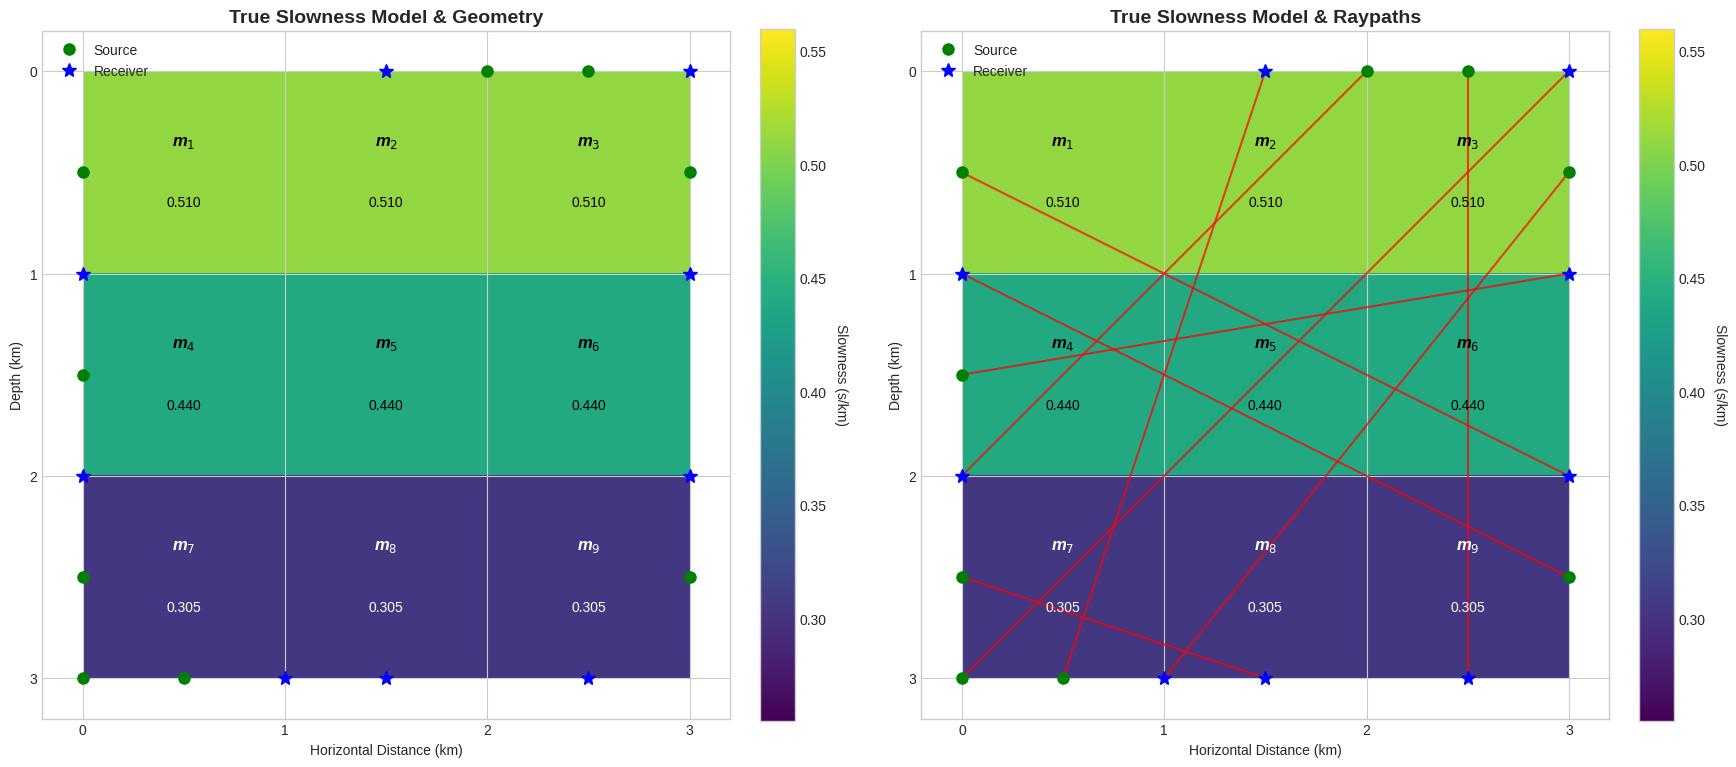

In [6]:
def build_G_matrix():
    """Builds the G matrix based on S-R geometry and grid."""
    G = np.zeros((N, M))
    n_steps = 1000
    for i in range(N):
        src, rcv = np.array(sources[i]), np.array(receivers[i])
        ray_vector = rcv - src
        ray_length = np.linalg.norm(ray_vector)
        for step in range(n_steps + 1):
            current_pos = src + (step / n_steps) * ray_vector
            x, y = current_pos[0], current_pos[1]
            if 0 <= x < NX*GRID_SIZE and 0 <= y < NY*GRID_SIZE:
                ix, iy = int(np.floor(x / GRID_SIZE)), int(np.floor(y / GRID_SIZE))
                j = iy * NX + ix
                G[i, j] += ray_length / n_steps
    return G

G = build_G_matrix()

# Check the invertibility of the G matrix
det_G = np.linalg.det(G)
cond_G = np.linalg.cond(G)

print("--- G Matrix Analysis ---")
print(f"G Matrix Shape: {G.shape}")
print(f"Determinant of G: {det_G:.4e}")
print(f"Condition Number of G: {cond_G:.2f}")
if abs(det_G) < 1e-9:
    print("\nWARNING: Determinant is very small. The matrix might be singular or ill-conditioned.")
else:
    print("\nThe G matrix appears to be well-conditioned and invertible.")

# Generate the two plots for this section
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: True Slowness Model & S-R Geometry
ax1 = axes[0]
plot_base_model_with_labels(ax1, m_true, 'True Slowness Model & Geometry')
plot_points_only(ax1)

# Plot 2: True Slowness Model & Raypaths
ax2 = axes[1]
plot_base_model_with_labels(ax2, m_true, 'True Slowness Model & Raypaths')
plot_raypaths_only(ax2)
plot_points_only(ax2)


plt.tight_layout(pad=3.0)
plt.show()

## 4. Task 1: Direct Inversion (Noiseless Data)
Calculate the synthetic data `d_true` using your unique `m_true` model and the G matrix. Then, perform a direct inversion to obtain the estimated model `m_est`.


--- TASK 1: Inversion with Noiseless Data ---

G Matrix:
 [[1.12  0.    0.    0.    1.117 1.117 0.    0.    0.   ]
 [0.    0.    1.002 0.    0.    0.999 0.    0.    0.999]
 [0.    1.411 0.003 1.411 0.003 0.    0.003 0.    0.   ]
 [0.    0.    0.637 0.    0.317 0.964 0.    1.281 0.   ]
 [0.    0.    0.    1.016 1.013 1.013 0.    0.    0.   ]
 [0.    0.    0.    1.12  1.117 0.    0.    0.    1.117]
 [0.    1.056 0.    0.525 0.528 0.    1.053 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.055 0.527 0.   ]
 [0.    0.    1.413 0.    1.413 0.    1.413 0.    0.   ]]

Noiseless Data d (travel times):
 [1.554 1.255 1.344 1.279 1.338 1.325 1.323 0.482 1.773]

Estimated Model m_est:
 [0.51  0.51  0.51  0.44  0.44  0.44  0.305 0.305 0.305]

True Model m_true (unique):
 [0.51  0.51  0.51  0.44  0.44  0.44  0.305 0.305 0.305]

RMS Error (m_est vs m_true): 0.000000


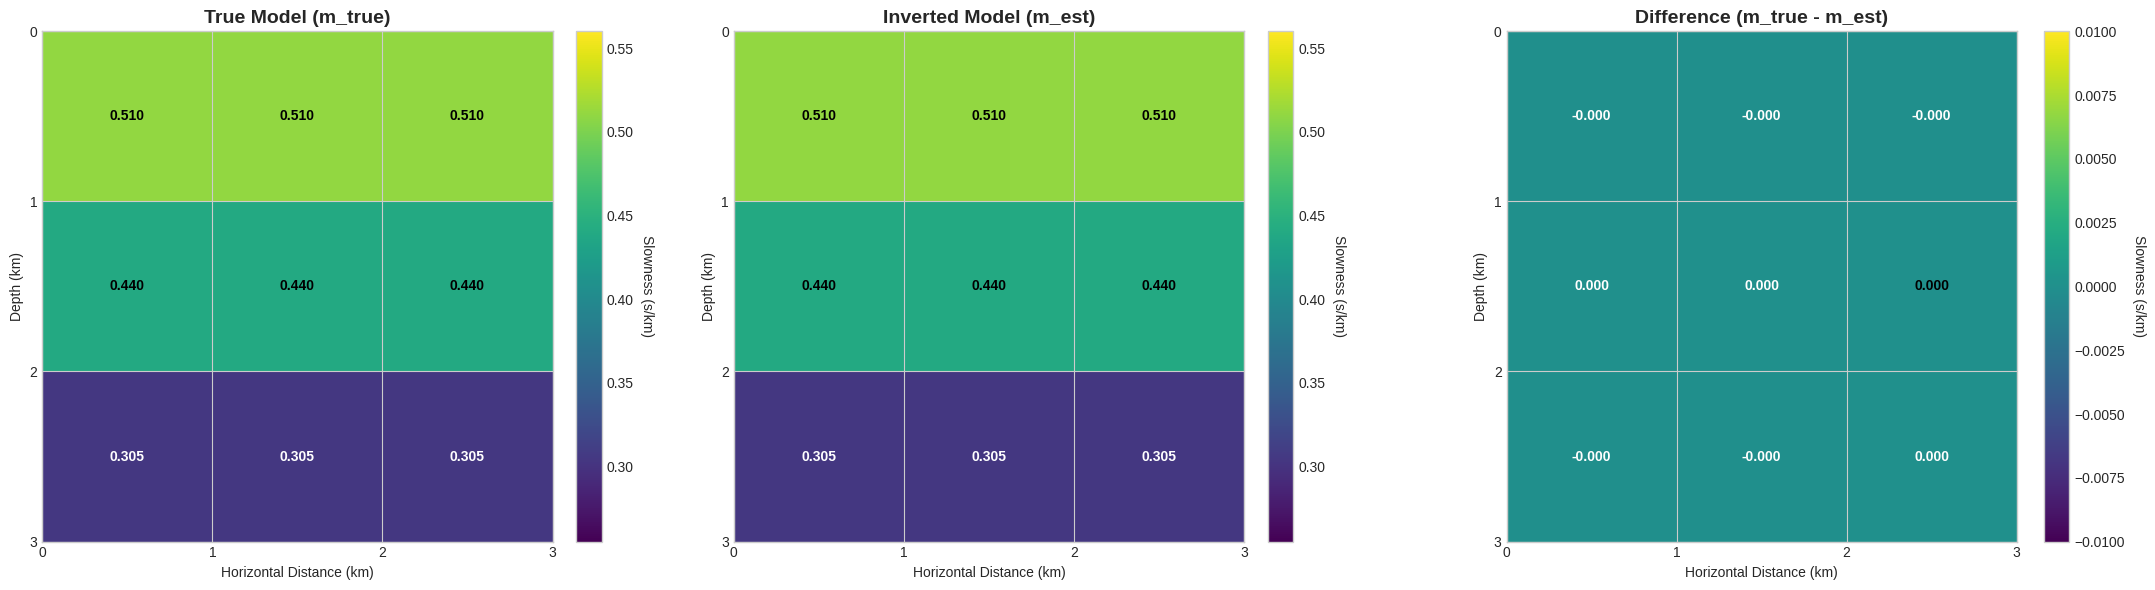

In [7]:
d_true = G @ m_true
G_inv = np.linalg.inv(G)
m_est_noiseless = G_inv @ d_true
error_noiseless = np.linalg.norm(m_est_noiseless - m_true)

print("--- TASK 1: Inversion with Noiseless Data ---")
print("\nG Matrix:\n", np.round(G, 3))
print("\nNoiseless Data d (travel times):\n", np.round(d_true, 3))
print("\nEstimated Model m_est:\n", np.round(m_est_noiseless, 3))
print("\nTrue Model m_true (unique):\n", np.round(m_true, 3))
print(f"\nRMS Error (m_est vs m_true): {error_noiseless:.6f}")

# Visualize Results
fig, axes = plt.subplots(1, 3, figsize=(22, 6), gridspec_kw={'width_ratios': [1, 1, 1.15]})
vmin, vmax = m_true.min() - 0.05, m_true.max() + 0.05

plot_model(m_true, 'True Model (m_true)', axes[0], vmin, vmax)
plot_model(m_est_noiseless, 'Inverted Model (m_est)', axes[1], vmin, vmax)
plot_model(m_true - m_est_noiseless, 'Difference (m_true - m_est)', axes[2], vmin=-0.01, vmax=0.01)

plt.tight_layout()
plt.show()

## 5. Task 2: Inversion with Data Noise
We will add random noise to the data `d_true` at 10 different levels and observe how the error in the estimated model (`m_est`) increases with the noise level.


--- TASK 2: Inversion with Data Noise ---
Data Noise: 0.0% | Model RMS Error: 0.0000
Data Noise: 3.0% | Model RMS Error: 0.0737
Data Noise: 6.0% | Model RMS Error: 0.0845
Data Noise: 9.0% | Model RMS Error: 0.1277
Data Noise: 12.0% | Model RMS Error: 0.1262
Data Noise: 15.0% | Model RMS Error: 0.3035
Data Noise: 18.0% | Model RMS Error: 0.1836
Data Noise: 21.0% | Model RMS Error: 0.1684
Data Noise: 24.0% | Model RMS Error: 0.1448
Data Noise: 27.0% | Model RMS Error: 0.6798
Data Noise: 30.0% | Model RMS Error: 0.2780


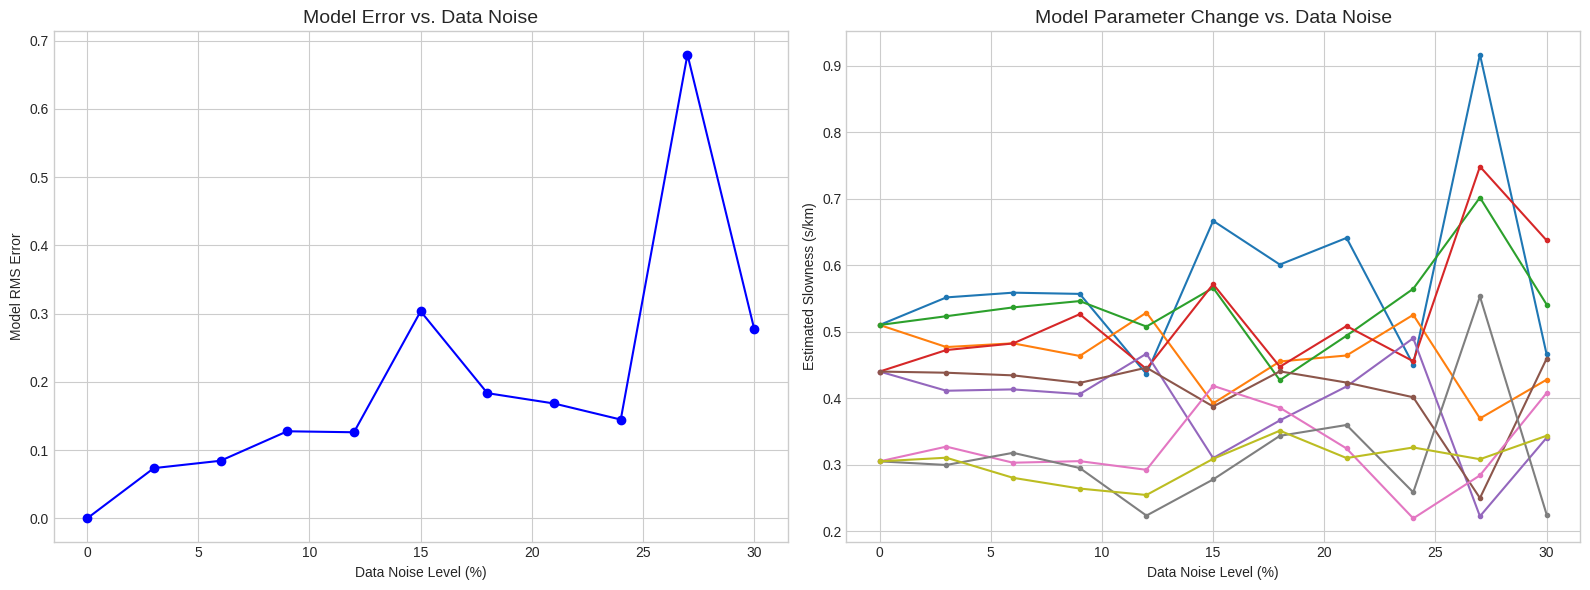

In [8]:
noise_levels_percent = np.linspace(0, 30, 11)  # 0% to 30%
model_errors_d_noise, estimated_slowness_list_d_noise = [], []
data_std = np.std(d_true)

print("--- TASK 2: Inversion with Data Noise ---")
for noise_percent in noise_levels_percent:
    noise_amplitude = data_std * (noise_percent / 100.0)
    noise = np.random.normal(0, noise_amplitude, N)
    d_noisy = d_true + noise
    m_est_noisy = G_inv @ d_noisy
    error = np.linalg.norm(m_est_noisy - m_true)
    model_errors_d_noise.append(error)
    estimated_slowness_list_d_noise.append(m_est_noisy)
    print(f"Data Noise: {noise_percent:.1f}% | Model RMS Error: {error:.4f}")

# Visualize Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(noise_levels_percent, model_errors_d_noise, 'o-', color='b')
axes[0].set_xlabel('Data Noise Level (%)')
axes[0].set_ylabel('Model RMS Error')
axes[0].set_title('Model Error vs. Data Noise', fontsize=14)
axes[0].grid(True)

estimated_slowness_array = np.array(estimated_slowness_list_d_noise)
for i in range(M):
    axes[1].plot(noise_levels_percent, estimated_slowness_array[:, i], '.-', label=f'Block {i+1}')
axes[1].set_xlabel('Data Noise Level (%)')
axes[1].set_ylabel('Estimated Slowness (s/km)')
axes[1].set_title('Model Parameter Change vs. Data Noise', fontsize=14)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Task 3: Inversion with G Matrix Perturbation

Here, we will add random errors to the `G` matrix itself. This simulates uncertainty in the physics, such as errors in determining raypath lengths. We will observe its effect on the inversion result and the condition number of G.


--- TASK 3: Inversion with G Matrix Perturbation ---
G Perturbation: 0.00% | Model RMS Error: 0.0000 | Cond. Num: 11.21
G Perturbation: 3.00% | Model RMS Error: 0.0548 | Cond. Num: 11.46
G Perturbation: 6.00% | Model RMS Error: 0.1013 | Cond. Num: 10.04
G Perturbation: 9.00% | Model RMS Error: 0.1112 | Cond. Num: 10.24
G Perturbation: 12.00% | Model RMS Error: 0.1902 | Cond. Num: 11.71
G Perturbation: 15.00% | Model RMS Error: 0.2230 | Cond. Num: 8.88
G Perturbation: 18.00% | Model RMS Error: 0.4479 | Cond. Num: 15.95
G Perturbation: 21.00% | Model RMS Error: 0.2181 | Cond. Num: 9.75
G Perturbation: 24.00% | Model RMS Error: 0.3159 | Cond. Num: 14.26
G Perturbation: 27.00% | Model RMS Error: 0.3960 | Cond. Num: 7.67
G Perturbation: 30.00% | Model RMS Error: 0.8516 | Cond. Num: 10.19


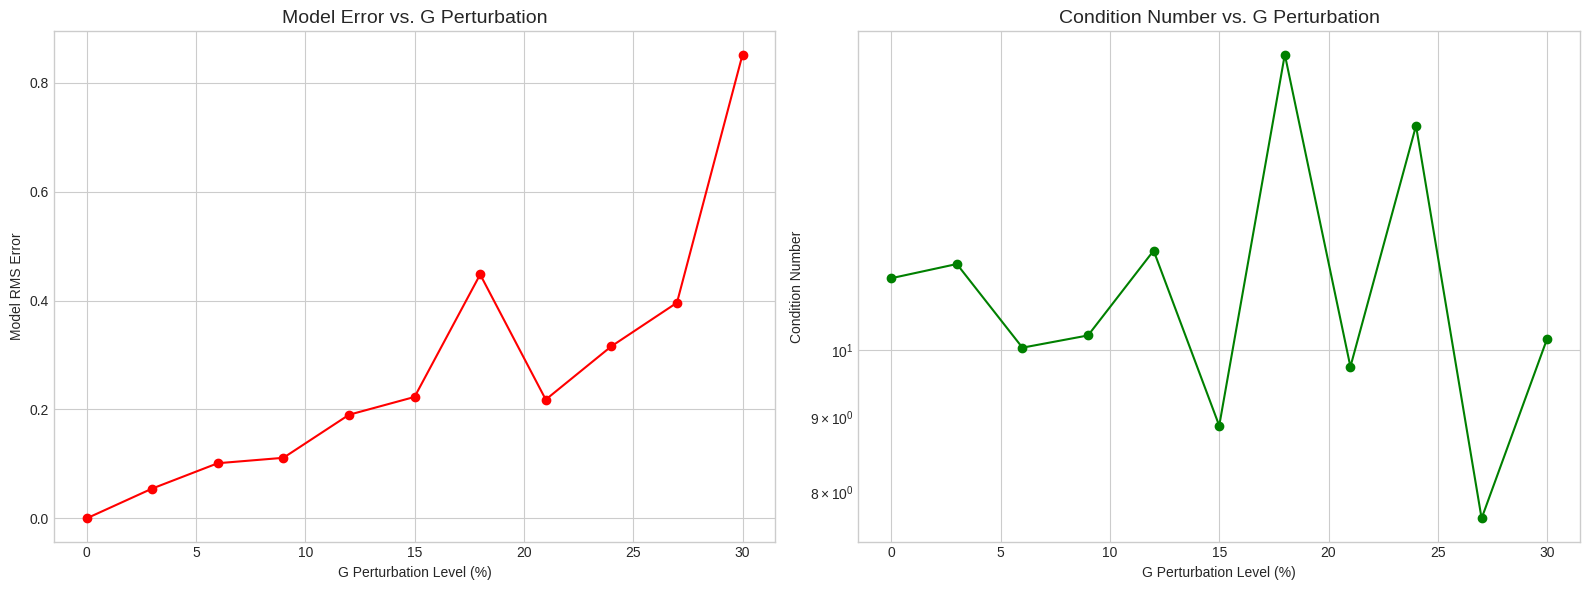

In [9]:
g_error_levels_percent = np.linspace(0, 30, 11)  # 0% to 30%
model_errors_g_error, condition_numbers_g_error, estimated_slowness_list_g_error = [], [], []
g_mean = np.mean(np.abs(G))

print("--- TASK 3: Inversion with G Matrix Perturbation ---")
for error_percent in g_error_levels_percent:
    error_amplitude = g_mean * (error_percent / 100.0)
    G_perturbation = np.random.normal(0, error_amplitude, G.shape)
    G_noisy = G + G_perturbation
    try:
        G_noisy_inv = np.linalg.inv(G_noisy)
        m_est_g_noisy = G_noisy_inv @ d_true
        error = np.linalg.norm(m_est_g_noisy - m_true)
        cond_num = np.linalg.cond(G_noisy)
        model_errors_g_error.append(error)
        condition_numbers_g_error.append(cond_num)
        estimated_slowness_list_g_error.append(m_est_g_noisy)
        print(f"G Perturbation: {error_percent:.2f}% | Model RMS Error: {error:.4f} | Cond. Num: {cond_num:.2f}")
    except np.linalg.LinAlgError:
        print(f"G Perturbation: {error_percent:.2f}% - G matrix became singular and could not be inverted.")
        model_errors_g_error.append(np.nan)
        condition_numbers_g_error.append(np.nan)
        estimated_slowness_list_g_error.append(np.full(M, np.nan))

# Visualize Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(g_error_levels_percent, model_errors_g_error, 'o-', color='r')
axes[0].set_xlabel('G Perturbation Level (%)')
axes[0].set_ylabel('Model RMS Error')
axes[0].set_title('Model Error vs. G Perturbation', fontsize=14)
axes[0].grid(True)

axes[1].plot(g_error_levels_percent, condition_numbers_g_error, 'o-', color='g')
axes[1].set_xlabel('G Perturbation Level (%)')
axes[1].set_ylabel('Condition Number')
axes[1].set_title('Condition Number vs. G Perturbation', fontsize=14)
axes[1].grid(True)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

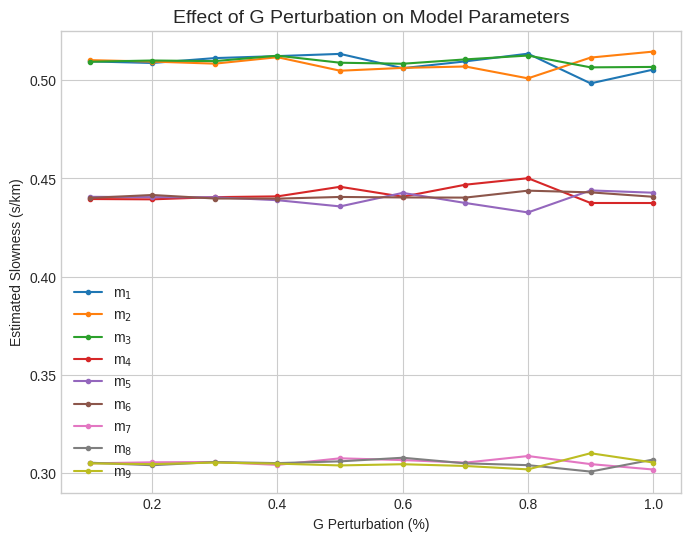

In [35]:
# ### (NEW) G Matrix Perturbation: Effect on Model Parameters
# This new plot replicates the graph from the mini-project instructions, showing how each individual model parameter (`m_1` to `m_9`) changes as the perturbation on the G matrix increases.

#%%
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
estimated_slowness_g_array = np.array(estimated_slowness_list_g_error)

for i in range(M):
    ax.plot(g_error_levels_percent, estimated_slowness_g_array[:, i], '.-', label=f'm$_{i+1}$')

ax.set_xlabel('G Perturbation (%)')
ax.set_ylabel('Estimated Slowness (s/km)')
ax.set_title('Effect of G Perturbation on Model Parameters', fontsize=14)
ax.grid(True)
ax.legend()
plt.show()

## 7. Task 4: Raypath Density Analysis (Required)
We will visualize the raypath density (`hit count matrix`) to answer the question, "How do model parameters change with the number of raypath segments passing through each cell?".


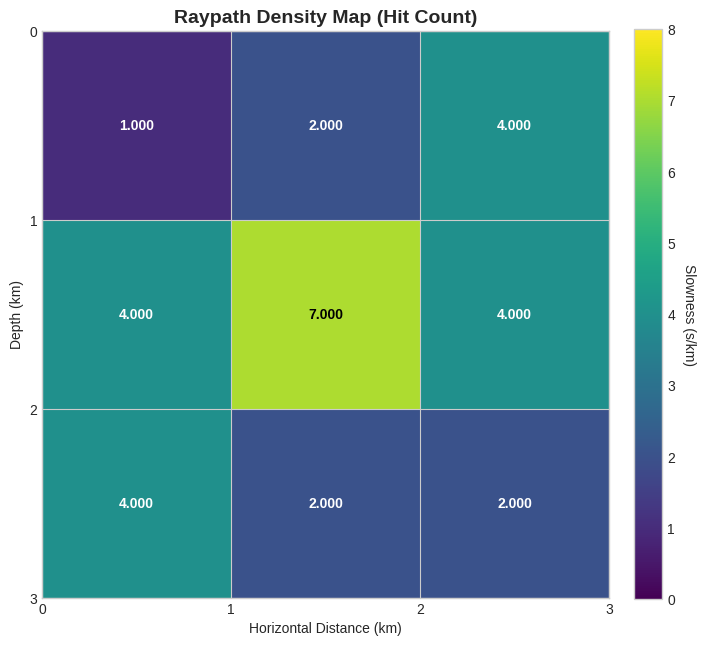

Hit Count per Block:
 [[1. 2. 4.]
 [4. 7. 4.]
 [4. 2. 2.]]

Analysis:
With an asymmetrical geometry, the hit count becomes non-uniform, which is a realistic scenario.
Blocks with a higher hit count (like the central blocks) are expected to have better resolution
and be more robust against noise compared to blocks with a lower hit count.


In [36]:
hit_count = np.zeros(M)
for j in range(M):
    hit_count[j] = np.count_nonzero(G[:, j])

# Visualize Hit Count
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_model(hit_count, 'Raypath Density Map (Hit Count)', ax, vmin=hit_count.min()-1, vmax=hit_count.max()+1)
plt.show()

print("Hit Count per Block:\n", hit_count.reshape(NY, NX))
print("\nAnalysis:")
print("With an asymmetrical geometry, the hit count becomes non-uniform, which is a realistic scenario.")
print("Blocks with a higher hit count (like the central blocks) are expected to have better resolution")
print("and be more robust against noise compared to blocks with a lower hit count.")